# Machine Learning Homework 1

## Lilian Huang

In [ ]:
# pip install sodapy
# brew install spatialindex
import pandas as pd
import numpy as np
from sodapy import Socrata
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
from census import Census
from us import states
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Problem 1.1

Download reported crime data from the Chicago open data portal for 2017 and 2018.

In [2]:
crime = "6zsd-86xi"
client = Socrata("data.cityofchicago.org", '1JQ1Cv2YCIo6EEoPZDoCenVbk')

def get_df(soc_client, year_str):
    where_clause = "date between '{}-01-01T00:00:00' and '{}-12-31T23:59:59'".format(year_str, year_str)
    results = soc_client.get(crime, where=where_clause, limit = 1000000)
    df = pd.DataFrame.from_records(results)
    return df

In [3]:
df_2017 = get_df(client, "2017")
df_2017.shape

(268096, 22)

In [4]:
df_2018 = get_df(client, "2018")
df_2018.shape

(266278, 22)

In [5]:
df_combined = pd.concat([df_2017, df_2018])
df_combined.shape

(534374, 22)

# Problem 1.2

Generate summary statistics for the crime reports data including but not limited to number of crimes of each type, how they change over time, and how they are different by neighborhood. Please use a combination of tables and graphs to present these summary stats.

## Number of crimes of each type

We see below, in both the table and chart, that the top most common types of crime are:
* theft (24% of total crimes)
* battery (19% of total crimes)
* criminal damage (11% of total crimes)

In [6]:
def make_percent_table(df, column):
    table = df.groupby(column).size().reset_index(name="count")
    table["percent"] = (table["count"]/len(df)) * 100
    return table

In [7]:
table = make_percent_table(df_combined, "primary_type")
table.sort_values(by="percent", ascending=False)

,primary_type,count,percent
30,THEFT,129428,24.220490
2,BATTERY,98995,18.525415
6,CRIMINAL DAMAGE,56848,10.638242
1,ASSAULT,39680,7.425511
8,DECEPTIVE PRACTICE,37764,7.066961
23,OTHER OFFENSE,34357,6.429392
3,BURGLARY,24730,4.627845
17,NARCOTICS,24646,4.612126
27,ROBBERY,21559,4.034440
16,MOTOR VEHICLE THEFT,21394,4.003563


In [8]:
def graph_primary_type(df, order_lst):
    sns.countplot(x="primary_type", data=df, order=order_lst)
    plt.xticks(rotation=90)
    plt.show()

In [9]:
lst = sorted(df_combined["primary_type"].unique())

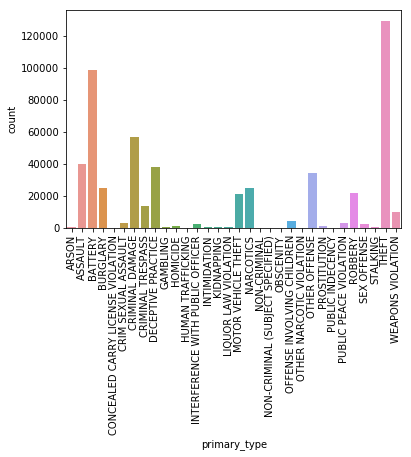

In [10]:
graph_primary_type(df_combined, lst)

## Change in crimes over time

We see that overall crime levels follow a seasonal pattern; crime is at its lowest in February, and rises sharply in spring, and reaches its highest in the summer months of July-August. It then decreases again in autumn and winter.

This pattern is the same in both 2017 and 2018, but in most months, 2018 crime was higher than 2017 crime; there was also a spike in crime in December 2018 that did not occur in December 2017.

However, notably, crime in February 2018 was substantially lower than crime in February 2017.

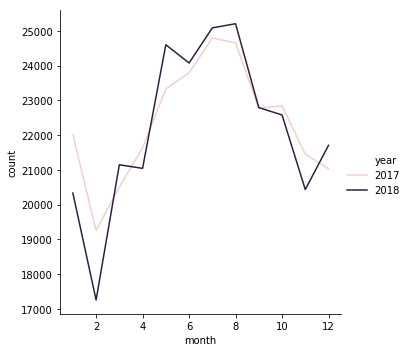

In [11]:
df_combined['date'] = pd.to_datetime(df_combined['date'])
df_combined['month'] = df_combined['date'].dt.month
month_counts = df_combined.groupby(["year", "month"]).size().to_frame().reset_index()
month_counts.rename(columns={0: "count"}, inplace=True)
month_counts['year'] = month_counts['year'].astype('int')
sns.relplot(x="month", y="count", hue="year", kind="line", legend="full", data=month_counts)
plt.show()

## Differences by neighborhood (community area)

The following table presents the level of overall crime in each neighborhood (community area).

We see the top 3 neighborhoods with the most crimes reported are:
* Austin (6% of all crimes)
* Near North Side (5% of all crimes)
* the Loop (4% of all crimes)

In [12]:
comm_areas = client.get("igwz-8jzy")
comm_areas_df = pd.DataFrame.from_records(comm_areas)
comm_areas_df = comm_areas_df[['area_num_1','community']]
df_combined = df_combined.merge(comm_areas_df, how='left', left_on=['community_area'], right_on=['area_num_1'])

In [13]:
areas = make_percent_table(df_combined, "community")
areas.sort_values(by="percent", ascending=False)

,community,count,percent
5,AUSTIN,30428,5.694139
47,NEAR NORTH SIDE,25367,4.747050
41,LOOP,21480,4.019657
49,NEAR WEST SIDE,18448,3.452264
52,NORTH LAWNDALE,18376,3.438790
65,SOUTH SHORE,17325,3.242111
32,HUMBOLDT PARK,16095,3.011935
75,WEST TOWN,15625,2.923982
4,AUBURN GRESHAM,14897,2.787748
70,WEST ENGLEWOOD,14017,2.623069


The type of crime also differs by neighborhood. For example, we see in the following table that the most murders occur in Austin, North Lawndale, and Englewood.

In [14]:
murders = df_combined[df_combined["primary_type"] == "HOMICIDE"]
murder_counts = murders.groupby("community").size().reset_index(name="count")
murder_counts.sort_values(by="count", ascending=False)

,community,count
4,AUSTIN,138
48,NORTH LAWNDALE,75
20,ENGLEWOOD,62
57,ROSELAND,58
61,SOUTH SHORE,58
28,HUMBOLDT PARK,51
3,AUBURN GRESHAM,51
17,EAST GARFIELD PARK,43
66,WEST ENGLEWOOD,41
46,NEW CITY,41


Meanwhile, the most thefts occur in the Near North Side, the Loop, and the Near West Side.

In [15]:
thefts = df_combined[df_combined["primary_type"] == "THEFT"]
theft_counts = thefts.groupby("community").size().reset_index(name="count")
theft_counts.sort_values(by="count", ascending=False)

,community,count
47,NEAR NORTH SIDE,12023
41,LOOP,11672
49,NEAR WEST SIDE,6944
75,WEST TOWN,5875
38,LINCOLN PARK,4735
37,LAKE VIEW,4582
5,AUSTIN,4446
40,LOGAN SQUARE,3529
14,CHATHAM,3066
65,SOUTH SHORE,2822


We also see that the frequency of different types of crime (i.e. the proportion of that type of crime, out of total crimes in the neighborhood) varies across neighborhoods, as seen in the following tables.

The proportion of thefts is highest in the Loop, Lincoln Park, and the Near North Side.

The proportion of batteries is highest in Riverdale, Washington Park, and Englewood.

The proportion of homicides is highest in Riverdale, Brighton Park, and Englewood.

We therefore see that the story changes when we look at the frequency of a type of crime, rather than the raw count of a type of crime.

In [16]:
numer = df_combined.groupby(["community", "primary_type"]).size()
denom = numer.groupby("community").transform("sum")
rate = (numer / denom) * 100
rate_df = rate.unstack()
rate_df[["THEFT", "BATTERY", "HOMICIDE"]]

primary_type,THEFT,BATTERY,HOMICIDE
community,,,
ALBANY PARK,25.551471,18.607026,0.102124
ARCHER HEIGHTS,22.809124,16.446579,0.240096
ARMOUR SQUARE,28.171091,18.190757,NaN
ASHBURN,19.389624,18.270600,0.183113
AUBURN GRESHAM,16.077062,22.407196,0.342351
AUSTIN,14.611542,22.091495,0.453530
AVALON PARK,18.036810,21.799591,0.327198
AVONDALE,28.687473,15.220180,0.171013
BELMONT CRAGIN,18.563141,19.433289,0.211959


In [17]:
rate_df["THEFT"].sort_values(ascending=False)

community
LOOP                      54.338920
LINCOLN PARK              49.994721
NEAR NORTH SIDE           47.396223
LAKE VIEW                 39.249615
NORTH CENTER              38.464338
NEAR WEST SIDE            37.640937
WEST TOWN                 37.600000
LOGAN SQUARE              35.385541
HYDE PARK                 34.845193
OHARE                     32.749774
NORTH PARK                31.926792
EDGEWATER                 31.871994
NEAR SOUTH SIDE           30.308626
FOREST GLEN               30.038388
LINCOLN SQUARE            29.778570
ROGERS PARK               28.708014
AVONDALE                  28.687473
ARMOUR SQUARE             28.171091
MOUNT GREENWOOD           27.328111
IRVING PARK               27.239959
UPTOWN                    27.161523
WEST LAWN                 27.070762
DOUGLAS                   27.034121
BEVERLY                   26.478718
KENWOOD                   25.970549
JEFFERSON PARK            25.766017
PULLMAN                   25.630983
ALBANY PARK       

In [18]:
rate_df["BATTERY"].sort_values(ascending=False)

community
RIVERDALE                 27.024030
WASHINGTON PARK           25.167360
ENGLEWOOD                 25.098814
GREATER GRAND CROSSING    24.409080
SOUTH CHICAGO             24.173228
SOUTH SHORE               24.132756
EAST GARFIELD PARK        23.934189
WEST ENGLEWOOD            23.457231
EAST SIDE                 23.166523
GRAND BOULEVARD           22.501121
WOODLAWN                  22.465454
AUBURN GRESHAM            22.407196
NEW CITY                  22.106925
AUSTIN                    22.091495
MONTCLARE                 21.825726
AVALON PARK               21.799591
CHICAGO LAWN              21.681997
WEST PULLMAN              21.643461
BRIGHTON PARK             21.581100
NORTH LAWNDALE            21.468219
SOUTH LAWNDALE            21.269561
ROSELAND                  21.066705
DOUGLAS                   20.978628
EDISON PARK               20.454545
WEST GARFIELD PARK        20.368187
CHATHAM                   20.362622
HEGEWISCH                 20.247295
SOUTH DEERING     

In [19]:
rate_df["HOMICIDE"].sort_values(ascending=False)

community
RIVERDALE                 0.665434
BRIGHTON PARK             0.636075
ENGLEWOOD                 0.510540
EAST SIDE                 0.474547
NEW CITY                  0.462441
AUSTIN                    0.453530
WEST PULLMAN              0.447539
EAST GARFIELD PARK        0.444950
ROSELAND                  0.419166
NORTH LAWNDALE            0.408141
WASHINGTON PARK           0.398046
WASHINGTON HEIGHTS        0.366943
WEST GARFIELD PARK        0.362746
CHICAGO LAWN              0.350416
AUBURN GRESHAM            0.342351
WOODLAWN                  0.342044
SOUTH SHORE               0.334776
AVALON PARK               0.327198
GAGE PARK                 0.320439
HUMBOLDT PARK             0.316869
SOUTH DEERING             0.314286
GRAND BOULEVARD           0.313761
GREATER GRAND CROSSING    0.296435
WEST ENGLEWOOD            0.292502
SOUTH CHICAGO             0.292463
BURNSIDE                  0.264901
MCKINLEY PARK             0.255363
MONTCLARE                 0.248963
ARCHER HEI

## Arrest rates

We also look at the arrest rates, i.e. the proportion of crimes for which an arrest was made.

The following table and chart show how arrest rate differs across the type of crime. We see that the crimes with the highest arrest rates tend to be straightforward, clear-cut administrative violations:
* Gambling
* Prostitution
* Public Indecency
* Narcotics
* Liquor Law Violation
* Concealed Carry License Violation

In [20]:
def calc_arrest_rates(df, column):
    counts = df.groupby(column).size()
    arrests = df_combined.groupby((column, "arrest")).size()
    arrest_rate = arrests / counts * 100.0
    arrest_rate_df = arrest_rate.unstack().reset_index()
    arrest_rate_df.drop([False], axis=1, inplace=True)
    arrest_rate_df.rename(columns={True: "arrest_rate"}, inplace=True)
    return arrest_rate_df

In [21]:
arrest_rate_per_type = calc_arrest_rates(df_combined, "primary_type")
arrest_rate_per_type.sort_values(by="arrest_rate", ascending=False)

arrest,primary_type,arrest_rate
9,GAMBLING,100.000000
24,PROSTITUTION,100.000000
25,PUBLIC INDECENCY,100.000000
17,NARCOTICS,99.955368
15,LIQUOR LAW VIOLATION,99.782135
4,CONCEALED CARRY LICENSE VIOLATION,96.788991
12,INTERFERENCE WITH PUBLIC OFFICER,95.190297
20,OBSCENITY,79.768786
31,WEAPONS VIOLATION,73.756906
26,PUBLIC PEACE VIOLATION,64.422742


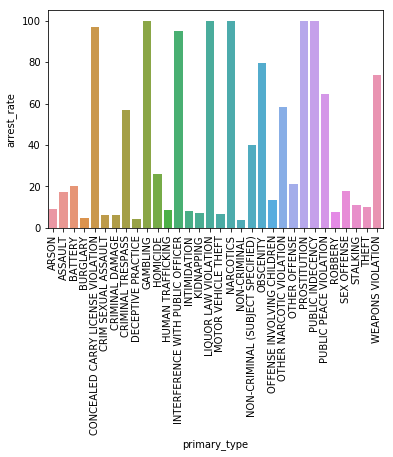

In [22]:
sns.barplot(x="primary_type", y="arrest_rate", data=arrest_rate_per_type)
plt.xticks(rotation=90)
plt.show()

Arrest rates also differ by community area. We see in the following table that the highest arrest rates are in:
* North Lawndale
* West Garfield Park
* Humboldt Park

In [23]:
arrest_rate_per_area = calc_arrest_rates(df_combined, "community")
arrest_rate_per_area.sort_values(by="arrest_rate", ascending=False)

arrest,community,arrest_rate
52,NORTH LAWNDALE,37.750327
71,WEST GARFIELD PARK,37.662102
32,HUMBOLDT PARK,32.177695
58,PULLMAN,31.679721
19,EAST GARFIELD PARK,28.114652
70,WEST ENGLEWOOD,25.897125
5,AUSTIN,25.614566
56,OHARE,25.143375
23,ENGLEWOOD,24.991765
61,ROSELAND,24.636843


# Problem 2

All of the crime data you just analyzed have a block address and lat/long fields. The task now is to augment that data with American Community Survey data. For each crime report, use one of the census APIs to get some additional data (at least 3-4 useful variables) about the block or zipcode where the crime report came from. This could include information about demographics of the block or zipcode (race, income, family size, etc.).
Based on this augmented data, provide some descriptive statistics to describe:
1. What types of blocks have reports of “Battery”?
2. What types of blocks get “Homicide”?
3. Does that change over time in the data you collected?
4. What is the difference in blocks that get “Deceptive Practice” vs “Sex Offense”?

In [24]:
c = Census("1006a1e4567f2582e57c3affbab639c19c930271", year=2017)
acs_data = c.acs5.get(('NAME', 'B01003_001E', 'B02001_002E', 'B02001_003E', 'B03002_012E', 'B19013_001E', 'B25010_001E', 'B01002_001E'), geo={'for': 'block group: *', 'in': 'state:{} county: 031'.format(states.IL.fips)})

In [25]:
acs_df = pd.DataFrame(acs_data)
acs_df.rename(columns={"B01003_001E": "total_popn", "B02001_002E": "white_alone", "B02001_003E": "black_alone", "B03002_012E": "hispanic", "B19013_001E": "median_income", "B25010_001E": "avg_household_size", "B01002_001E": "median_age"}, inplace=True)
acs_df['GEOID'] = acs_df['state'] + acs_df['county'] + acs_df['tract'] + acs_df['block group']

In [26]:
shp = gpd.read_file('cb_2017_17_bg_500k/cb_2017_17_bg_500k.shp')
shp['geometry'] = shp['geometry'].apply(Polygon)

In [27]:
df_combined['geometry'] = list(zip(pd.to_numeric(df_combined["longitude"]), pd.to_numeric(df_combined["latitude"])))
df_combined['geometry'] = df_combined['geometry'].apply(Point)
gdf = gpd.GeoDataFrame(df_combined, geometry='geometry')
gdf = gdf[gdf['geometry'].is_valid]
gdf.crs = {'init': 'epsg:4326'}

In [28]:
acs_with_latlong = shp.merge(acs_df, on='GEOID', how='right')
acs_with_latlong.shape
acs_with_latlong.head()
acs_with_latlong = acs_with_latlong[acs_with_latlong['geometry'].is_valid]
acs_with_latlong['geometry'] = acs_with_latlong['geometry'].apply(Polygon)
acs_with_latlong.crs = {'init': 'epsg:4269'}
acs_with_latlong = acs_with_latlong.to_crs({'init': 'epsg:4326'})

In [29]:
join = gpd.sjoin(gdf, acs_with_latlong, how="inner", op="within")

In [30]:
def percent_calc(out_col, in_col):
    out_colname = "percent_" + out_col
    join[out_colname] = (pd.to_numeric(join[in_col])/ pd.to_numeric(join["total_popn"])) * 100.0

In [31]:
percent_calc("black", "black_alone")
percent_calc("white", "white_alone")
percent_calc("hispanic", "hispanic")

In [32]:
cleaned = join.replace(-666666666.0, np.nan)

## Battery reports

The blocks that have reports of “Battery” are, on average:
* 58% black
* 28% white
* 20% Hispanic

(Please note that the ACS records Hispanic origin separately from race.)

They also have a median income of around $44,500, an average household size of 2.7 members, and a median age of 35.

In [33]:
STATS_DICT = {'percent_black': 'mean', 'percent_white': 'mean', 'percent_hispanic': 'mean', 'median_income': 'mean', 'avg_household_size': 'mean', 'median_age': 'mean'}

In [34]:
def get_stats(df):
    return df.agg(STATS_DICT)

In [35]:
batt = cleaned[cleaned.primary_type == "BATTERY"]
get_stats(batt)

percent_black            58.182852
percent_white            27.882498
percent_hispanic         19.745264
median_income         44486.095568
avg_household_size        2.748707
median_age               35.010691
dtype: float64

## Homicide reports

The blocks that have reports of “Homicide” are, on average:
* 73% black
* 16% white
* 18% Hispanic

(Please note that the ACS records Hispanic origin separately from race.)

They also have a median income of around $35,700, an average household size of 2.9 members, and a median age of 34.

In [36]:
hom = cleaned[cleaned.primary_type == "HOMICIDE"]
get_stats(hom)

percent_black            72.605703
percent_white            15.786123
percent_hispanic         17.519092
median_income         35694.726180
avg_household_size        2.923452
median_age               34.466667
dtype: float64

## Change over time in battery and homicide blocks

In [37]:
batt_by_month = get_stats(batt.groupby(["month", "year"])).reset_index()

In [38]:
hom_by_month = get_stats(hom.groupby(["month", "year"])).reset_index()

In [39]:
def make_graphs(df, y_val, ax_limits=(0, 100)):
    df['year'] = df['year'].astype('int')
    sns.relplot(x="month", y=y_val, hue="year", kind="line", legend="full", data=df)
    lower, upper = ax_limits
    plt.ylim(lower, upper)
    plt.show()

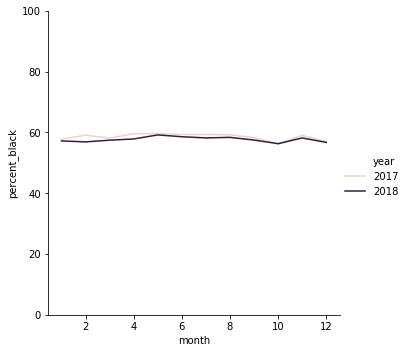

In [40]:
make_graphs(batt_by_month, "percent_black", (0, 100))

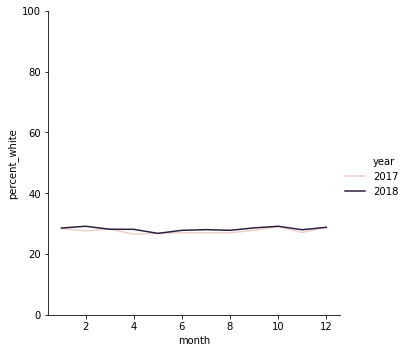

In [41]:
make_graphs(batt_by_month, "percent_white", (0, 100))

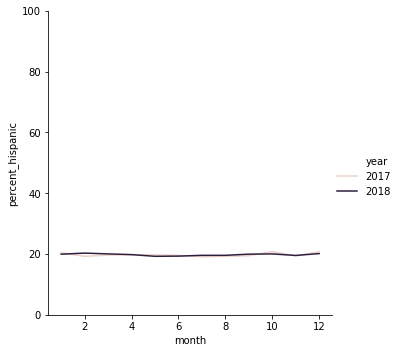

In [42]:
make_graphs(batt_by_month, "percent_hispanic", (0, 100))

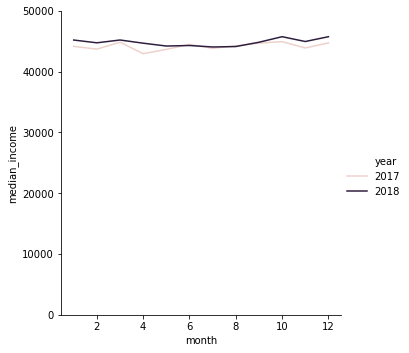

In [43]:
make_graphs(batt_by_month, "median_income", (0, 50000))

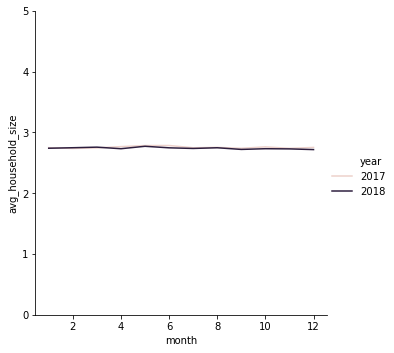

In [44]:
make_graphs(batt_by_month, "avg_household_size", (0, 5))

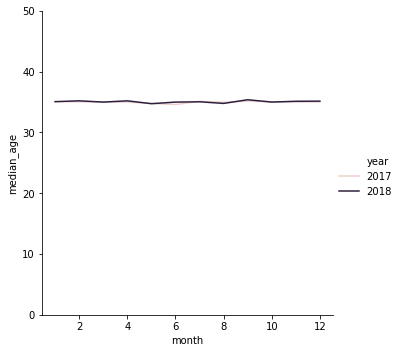

In [45]:
make_graphs(batt_by_month, "median_age", (0, 50))

We see from the above graphs that the type of blocks which report battery stay generally the same on all demographic variables - both from month to month, and between 2017 and 2018.

In contrast, the graphs below show that the type of blocks which report homicide display temporal variation. Most notably:
* In August 2017, there was a spike in the average white population (as measured by the proportion of the total population that is white) in homicide blocks, and a corresponding dip in the average black population. In other words, homicides were being committed on "whiter" blocks.
* There was also a spike in the average Hispanic population in homicide blocks that month (August 2017). Since the ACS records Hispanic origin separately from race, this indicates that homicides were being committed on blocks with more white residents of Hispanic origin.
* In March 2017, there was a spike in the median age of homicide blocks.

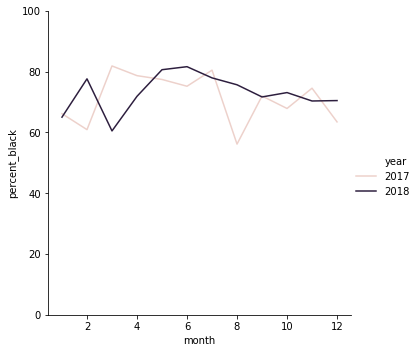

In [46]:
make_graphs(hom_by_month, "percent_black", (0, 100))

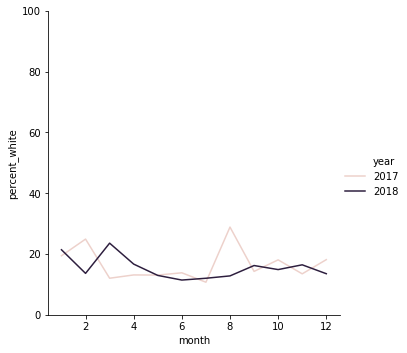

In [47]:
make_graphs(hom_by_month, "percent_white", (0, 100))

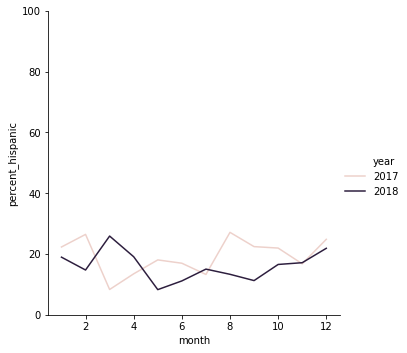

In [48]:
make_graphs(hom_by_month, "percent_hispanic", (0, 100))

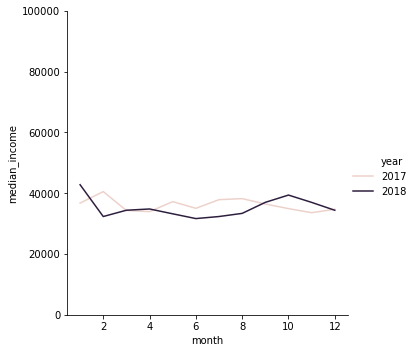

In [49]:
make_graphs(hom_by_month, "median_income", (0, 100000))

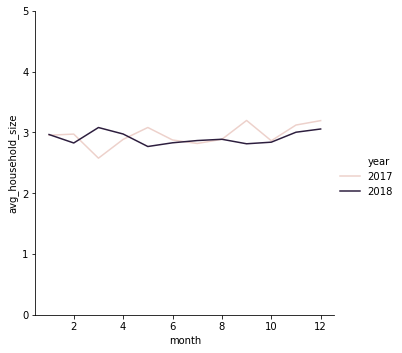

In [50]:
make_graphs(hom_by_month, "avg_household_size", (0, 5))

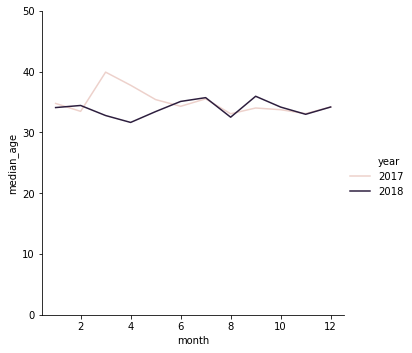

In [51]:
make_graphs(hom_by_month, "median_age", (0, 50))

## “Deceptive Practice” vs “Sex Offense”

Blocks that get reports of "Deceptive Practice" generally:
* Have a lower proportion of black population
* Have a higher proportion of white population
* Have a lower proportion of Hispanic population
* Have higher median income (about $14,000 higher)
* Have a smaller average household size

as compared to blocks that get reports of "Sex Offense".

In [52]:
subset = cleaned[(cleaned["primary_type"] == "DECEPTIVE PRACTICE") | (cleaned["primary_type"] == "SEX OFFENSE")]
get_stats(subset.groupby("primary_type"))

,percent_black,percent_white,percent_hispanic,median_income,avg_household_size,median_age
primary_type,,,,,,
DECEPTIVE PRACTICE,35.224491,47.649675,18.145316,67163.069591,2.417745,35.612380
SEX OFFENSE,40.517119,41.941993,25.111548,53274.433386,2.663821,35.489638


# Problem 3.1

## Change from 2017 to 2018

We see from the overall number of reports each year that there were about 2000 fewer crimes reported in 2018 than 2017.

From the following table and graphs, we can see that the types of crime which had the largest (proportional) increase from 2017 to 2018 were (only looking at types of crime which had more than 10 reports in both years):
* Concealed Carry License Violation
* Liquor Law Violation
* Interference with Public Officer
* Weapons Violation
* Narcotics

In contrast, the types of crime which had the largest (proportional) decrease from 2017 to 2018 were (only looking at types of crime which had more than 10 reports in both years):
* Robbery
* Arson
* Homicide
* Motor Vehicle Theft
* Kidnapping

In [53]:
df_2017.shape

(268096, 22)

In [54]:
df_2018.shape

(266278, 22)

In [55]:
types_2017 = make_percent_table(df_2017, "primary_type")

In [56]:
types_2018 = make_percent_table(df_2018, "primary_type")

In [57]:
def get_pct_change(for_2017, for_2018):
    combined = for_2017.merge(for_2018, how="outer", on="primary_type", suffixes=('_2017', '_2018'))
    combined["change_from_2017"] = (combined["count_2018"] - combined["count_2017"])
    combined["pct_change_from_2017"] = (combined["change_from_2017"] / combined["count_2017"]) * 100
    return combined

In [58]:
combined_types = get_pct_change(types_2017, types_2018)
combined_types.sort_values(by="pct_change_from_2017", ascending=False)

,primary_type,count_2017,percent_2017,count_2018,percent_2018,change_from_2017,pct_change_from_2017
4,CONCEALED CARRY LICENSE VIOLATION,69,0.025737,149,0.055957,80,115.942029
11,HUMAN TRAFFICKING,9,0.003357,14,0.005258,5,55.555556
19,NON-CRIMINAL (SUBJECT SPECIFIED),2,0.000746,3,0.001127,1,50.000000
15,LIQUOR LAW VIOLATION,191,0.071243,268,0.100647,77,40.314136
25,PUBLIC INDECENCY,10,0.003730,14,0.005258,4,40.000000
12,INTERFERENCE WITH PUBLIC OFFICER,1086,0.405079,1305,0.490089,219,20.165746
31,WEAPONS VIOLATION,4686,1.747881,5450,2.046733,764,16.303884
17,NARCOTICS,11658,4.348442,12988,4.877609,1330,11.408475
13,INTIMIDATION,151,0.056323,168,0.063092,17,11.258278
29,STALKING,188,0.070124,203,0.076236,15,7.978723


In [59]:
lst_2017 = sorted(df_2017["primary_type"].unique())
lst_2018 = sorted(df_2018["primary_type"].unique())

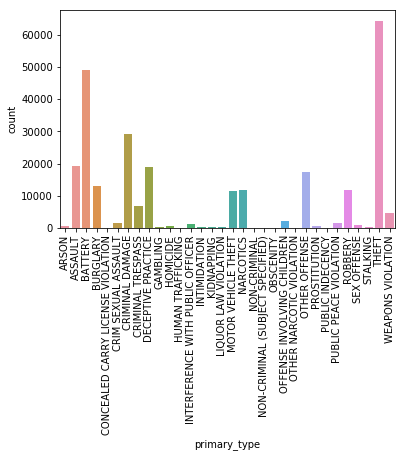

In [60]:
graph_primary_type(df_2017, lst_2017)

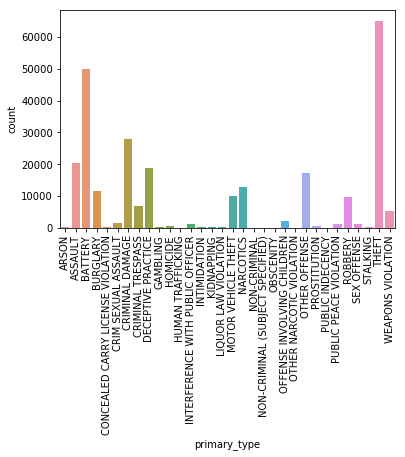

In [61]:
graph_primary_type(df_2018, lst_2018)

# Problem 3.2

One of the alderman candidates from recent elections has some crime statistics on
his website: https://www.ringer4results.com/node/8 

Specifically:
 
Crime is a major issue in our neighborhoods over the last four years, and the data shows just that.
Let’s break down the Chicago Police Department’s report for the month leading up to July 26, 2018, compared to the same week in 2017:

• Robberies -- up 21 percent over the same time-frame in 2017

• Aggravated batteries -- up 136 percent

• Burglaries -- an increase of 50 percent

• Motor vehicle theft -- up 41 percent.
 All told, crime rose 16 percent in the same 28-day time period in just one year. But take a look at the year-to-date number and you’ll see how crime has affected our local neighborhoods in a four-year period:

• Rose 10 percent since 2017

• Rose 22 percent since 2016

A. Are these statistics correct?

In [62]:
date_filter_2017 = (df_combined['date'] >= '2017-6-29') & (df_combined['date'] <= '2017-7-26')
date_filter_2018 = (df_combined['date'] >= '2018-6-29') & (df_combined['date'] <= '2018-7-26')
period_2017 = df_combined[date_filter_2017]
period_2018 = df_combined[date_filter_2018]
period_2017.shape

(21568, 26)

In [63]:
period_2018.shape

(21954, 26)

The overall amount of crime in this 28-day time period only increased by 1.79% from 2017 (21,568 crimes) to 2018 (21,954 crimes), so the "crime rose 16 percent in the same 28-day time period in just one year" statistic is incorrect.

We also see in the following table that:

* Robberies decreased by 10% from the same timeframe in 2017

* Aggravated batteries increased by 8% from the same timeframe in 2017

* Burglaries decreased by 6% from the same timeframe in 2017

* Motor vehicle theft decreased by 14% from the same timeframe in 2017

Therefore, all the statistics are incorrect.

In [64]:
((len(period_2018) - len(period_2017)) / len(period_2017)) * 100

1.7896884272997033

In [65]:
types_period_2017 = period_2017.groupby("primary_type").size().reset_index(name="count")
types_period_2018 = period_2018.groupby("primary_type").size().reset_index(name="count")
combined_periods = get_pct_change(types_period_2017, types_period_2018)
combined_periods

,primary_type,count_2017,count_2018,change_from_2017,pct_change_from_2017
0,ARSON,33.0,34.0,1.0,3.030303
1,ASSAULT,1593.0,1712.0,119.0,7.470182
2,BATTERY,4058.0,4359.0,301.0,7.417447
3,BURGLARY,1049.0,986.0,-63.0,-6.005720
4,CONCEALED CARRY LICENSE VIOLATION,5.0,11.0,6.0,120.000000
5,CRIM SEXUAL ASSAULT,131.0,133.0,2.0,1.526718
6,CRIMINAL DAMAGE,2386.0,2346.0,-40.0,-1.676446
7,CRIMINAL TRESPASS,555.0,501.0,-54.0,-9.729730
8,DECEPTIVE PRACTICE,1407.0,1458.0,51.0,3.624733
9,GAMBLING,12.0,38.0,26.0,216.666667


Since the alderman specifically highlighted aggravated batteries, we calculate the percentage change for that separately.

In [66]:
agg_batt_2017_filter = (period_2017['primary_type'] == 'BATTERY') & (period_2017['description'].str.contains('AGG'))
agg_batt_2018_filter = (period_2018['primary_type'] == 'BATTERY') & (period_2018['description'].str.contains('AGG'))
agg_batt_2017 = period_2017[agg_batt_2017_filter]
agg_batt_2018 = period_2018[agg_batt_2018_filter]
((len(agg_batt_2018) - len(agg_batt_2017)) / len(agg_batt_2017)) * 100

7.603092783505154

Even if the statistics were correct, I would consider them misleading because he implies that crime uniformly affects all neighborhoods, and it does not - as shown previously, the number and type of crimes varies across neighborhoods.

# Problem 3.3

The 5 key findings I would provide to the new mayor’s office, about crime in Chicago and what they should focus on in order to deal with crime in Chicago, are as follows:
* Crime is highest in summer months, especially July and August, so greater attention should be paid then.
* Different types of crime are more predominant in different geographic areas (with different demographic characteristics). It may be worth constructing neighborhood or block profiles to identify hotspots and risk factors for certain types of crime.
* That being said, homicides do not occur exclusively in blocks with certain demographic characteristics; the location of homicides varies noticeably over the course of a year. Therefore, predictive policing of particular blocks may not be the most effective way of preventing homicides.
* Arrest rates are highest for clear-cut administrative violations like liquor law violations, but are remarkably low for crimes including criminal sexual assault, robberies, and burglaries. It may be worth focusing efforts there to investigate the low arrest rates.
* While property crimes (burglaries, robberies) and homicides decreased from 2017 to 2018, other types of crimes rose, such as narcotics crimes and weapons-related offenses (concealed carry license violations, weapons violations). It may be worth being on the lookout to see if these crimes continue to increase.

# Problem 3.4

The key caveats of my recommendations, and limitations of my preceding analysis, include:
* The data only contains reported incidents of crime, and thus omits crimes that were not reported for any reason.
* The data is only from two years, and thus is a highly limited sample. We cannot necessarily conclude that the patterns witnessed in these data are representative of long-term Chicago crime trends.
* I looked only at the raw number of crimes in a community area, rather than the number of crimes per capita. A higher number of crime reports may be naturally associated with a larger population, rather than being correlated with demographic characteristics.
* I only looked at the "primary type" of crime reports given in the data, which are somewhat fine-grained, because I lack the domain knowledge to group together crimes. But such broader categories - e.g. violent crime, property crime, white-collar crime - may be more useful for analysis.
* Crimes are not necessarily committed by neighborhood residents, so looking at demographic data of neighborhood residents may not necessarily provide demographic profiles of the criminals.

# Problem 4.1

Assume you are running the 911 call center for Chicago. You get a call from someone at 2111 S Michigan Ave

A. Of the types of crimes you have data for, which crime type is the most likely given the call came from 2111 S Michigan Ave? What are the probabilities for each type of request?

In [67]:
near_south_side = df_combined[df_combined["community"] == "NEAR SOUTH SIDE"]
near_south_side["primary_type"].value_counts()

THEFT                                1149
BATTERY                               589
DECEPTIVE PRACTICE                    564
CRIMINAL DAMAGE                       345
OTHER OFFENSE                         226
ASSAULT                               216
MOTOR VEHICLE THEFT                   161
ROBBERY                               142
CRIMINAL TRESPASS                     138
BURGLARY                               93
NARCOTICS                              37
SEX OFFENSE                            24
CRIM SEXUAL ASSAULT                    21
WEAPONS VIOLATION                      20
OFFENSE INVOLVING CHILDREN             17
PUBLIC PEACE VIOLATION                 13
LIQUOR LAW VIOLATION                    7
PROSTITUTION                            6
INTERFERENCE WITH PUBLIC OFFICER        5
OBSCENITY                               3
ARSON                                   3
HOMICIDE                                3
STALKING                                3
NON-CRIMINAL                      

The address is in the Near South Side, where theft is the most likely.

The probabilities of each type of request are in the following table.

In [68]:
def get_probs(df, col):
    rv = (df.groupby(col).size().div(len(df))) * 100
    return rv

In [69]:
get_probs(near_south_side, "primary_type")

primary_type
ARSON                                 0.079135
ASSAULT                               5.697705
BATTERY                              15.536798
BURGLARY                              2.453179
CONCEALED CARRY LICENSE VIOLATION     0.026378
CRIM SEXUAL ASSAULT                   0.553944
CRIMINAL DAMAGE                       9.100501
CRIMINAL TRESPASS                     3.640200
DECEPTIVE PRACTICE                   14.877341
HOMICIDE                              0.079135
INTERFERENCE WITH PUBLIC OFFICER      0.131891
INTIMIDATION                          0.052757
KIDNAPPING                            0.026378
LIQUOR LAW VIOLATION                  0.184648
MOTOR VEHICLE THEFT                   4.246901
NARCOTICS                             0.975996
NON-CRIMINAL                          0.052757
OBSCENITY                             0.079135
OFFENSE INVOLVING CHILDREN            0.448430
OTHER OFFENSE                         5.961488
PROSTITUTION                          0.158270


# Problem 4.2

B. Let’s now assume that a call comes in about Theft. Which is more likely–that the call came from Garfield Park or Uptown? How much more or less likely is it to be from Garfield Park vs Uptown?

Assuming that "Garfield Park" encompasses both East and West Garfield Park, it is more likely that the call came from Garfield Park. There is a 0.42% higher probability that it is from Garfield Park.

In [70]:
theft = df_combined[df_combined["primary_type"] == "THEFT"]
probs = get_probs(theft, "community")
(probs.loc["EAST GARFIELD PARK"] + probs.loc["WEST GARFIELD PARK"]) - probs.loc["UPTOWN"]

0.41722038507896286

# Problem 4.3

C. Now assume that you don’t have access to all the raw data and you know the following things:
There are a total of 1000 calls, 600 from Garfield Park and 400 from Uptown. Of the 600 calls from Garfield Park, 100 of them are about Battery. Of the 400 calls from Uptown, 160 are about Battery. If a call comes about Battery, how much more/less likely is it that the call came from Garfield Park versus Uptown?

Applying Bayes's theorem:

P(Battery|Garfield Park) = 100/600

P(Battery|Uptown) = 160/400

P(Garfield Park) = 600/1000

P(Uptown) = 400/1000

P(Battery) = (100+160)/1000 = 260/1000

P(Garfield Park|Battery) = ((600/1000) * (100/600)) / (260/1000)

In [71]:
((600/1000) * (100/600)) / (260/1000)

0.3846153846153846

The probability that the call came from Garfield Park is 0.38.

P(Uptown|Battery) = ((400/1000) * (160/400)) / (260/1000)

In [72]:
((400/1000) * (160/400)) / (260/1000)

0.6153846153846155

The probability that the call came from Uptown is 0.62.

In [73]:
(((400/1000) * (160/400)) / (260/1000)) - (((600/1000) * (100/600)) / (260/1000))

0.23076923076923095

There is a 0.23 higher probability that the call came from Uptown.